In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Важная настройка для корректной настройки pipeline!
import sklearn
sklearn.set_config(transform_output="pandas")

# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, OrdinalEncoder
from category_encoders.target_encoder import TargetEncoder

from sklearn.model_selection import GridSearchCV, KFold

# for model learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score

#models
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from catboost import CatBoostRegressor

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error


# tunning hyperparamters model
import optuna


### 1. Запись данных

In [2]:
train = pd.read_csv("/home/savely/ds_bootcamp/ds-phase-1/House_Prices_project/data/train.csv")
test = pd.read_csv("/home/savely/ds_bootcamp/ds-phase-1/House_Prices_project/data/test.csv")
submission = pd.read_csv("/home/savely/ds_bootcamp/ds-phase-1/House_Prices_project/data/sample_submission.csv")

### 2. Информация о датафрейме

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train.shape, test.shape

((1460, 81), (1459, 80))

In [5]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [6]:
train["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

### 3. Визуализация данных 

In [7]:
cat_features = train.select_dtypes(include="object")
num_features = train.select_dtypes(include=["int64", "float64"])

#### Распределение цены

/home/savely/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


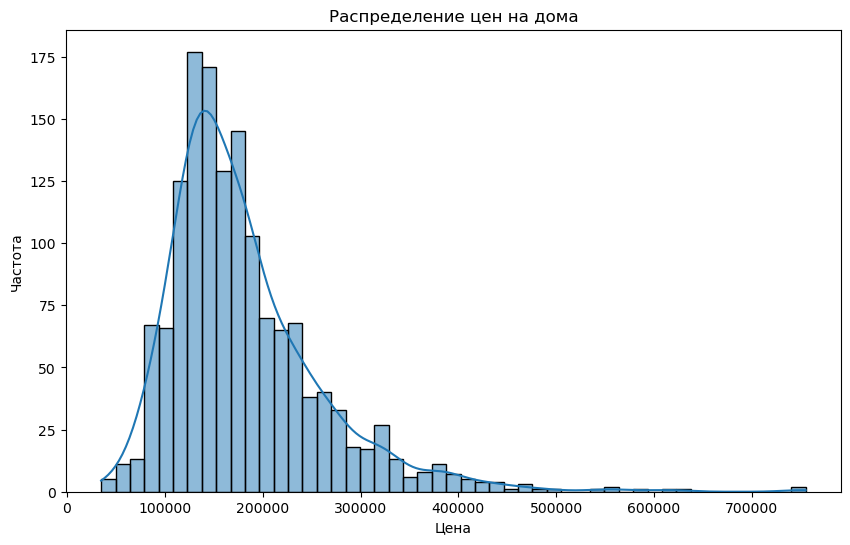

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(data=train, x="SalePrice", kde=True)
plt.title('Распределение цен на дома')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.show()

#### Распределение цены (таргет логарифмированный)

/home/savely/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


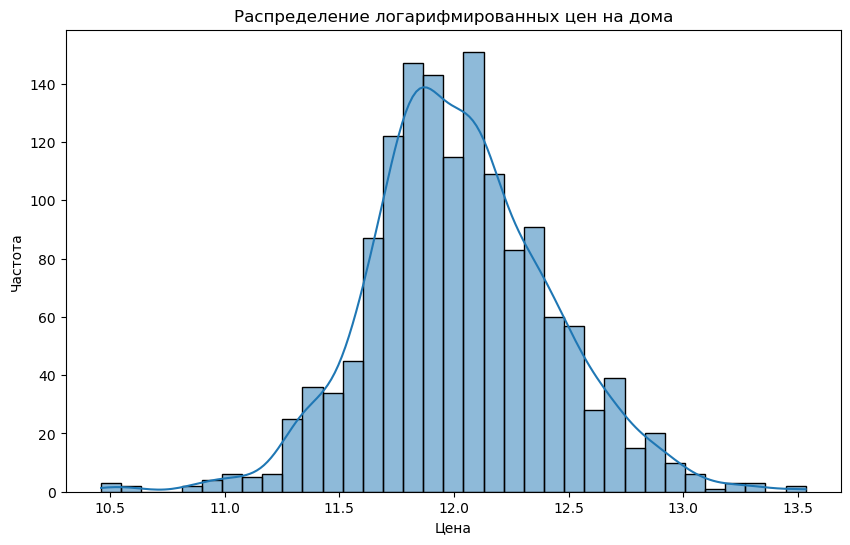

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(data=train, x=np.log(train["SalePrice"]), kde=True)
plt.title('Распределение логарифмированных цен на дома')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.show()

### 4. Корреляция признаков между собой и по таргету

### Визуализация корреляции численных фичей

<Axes: >

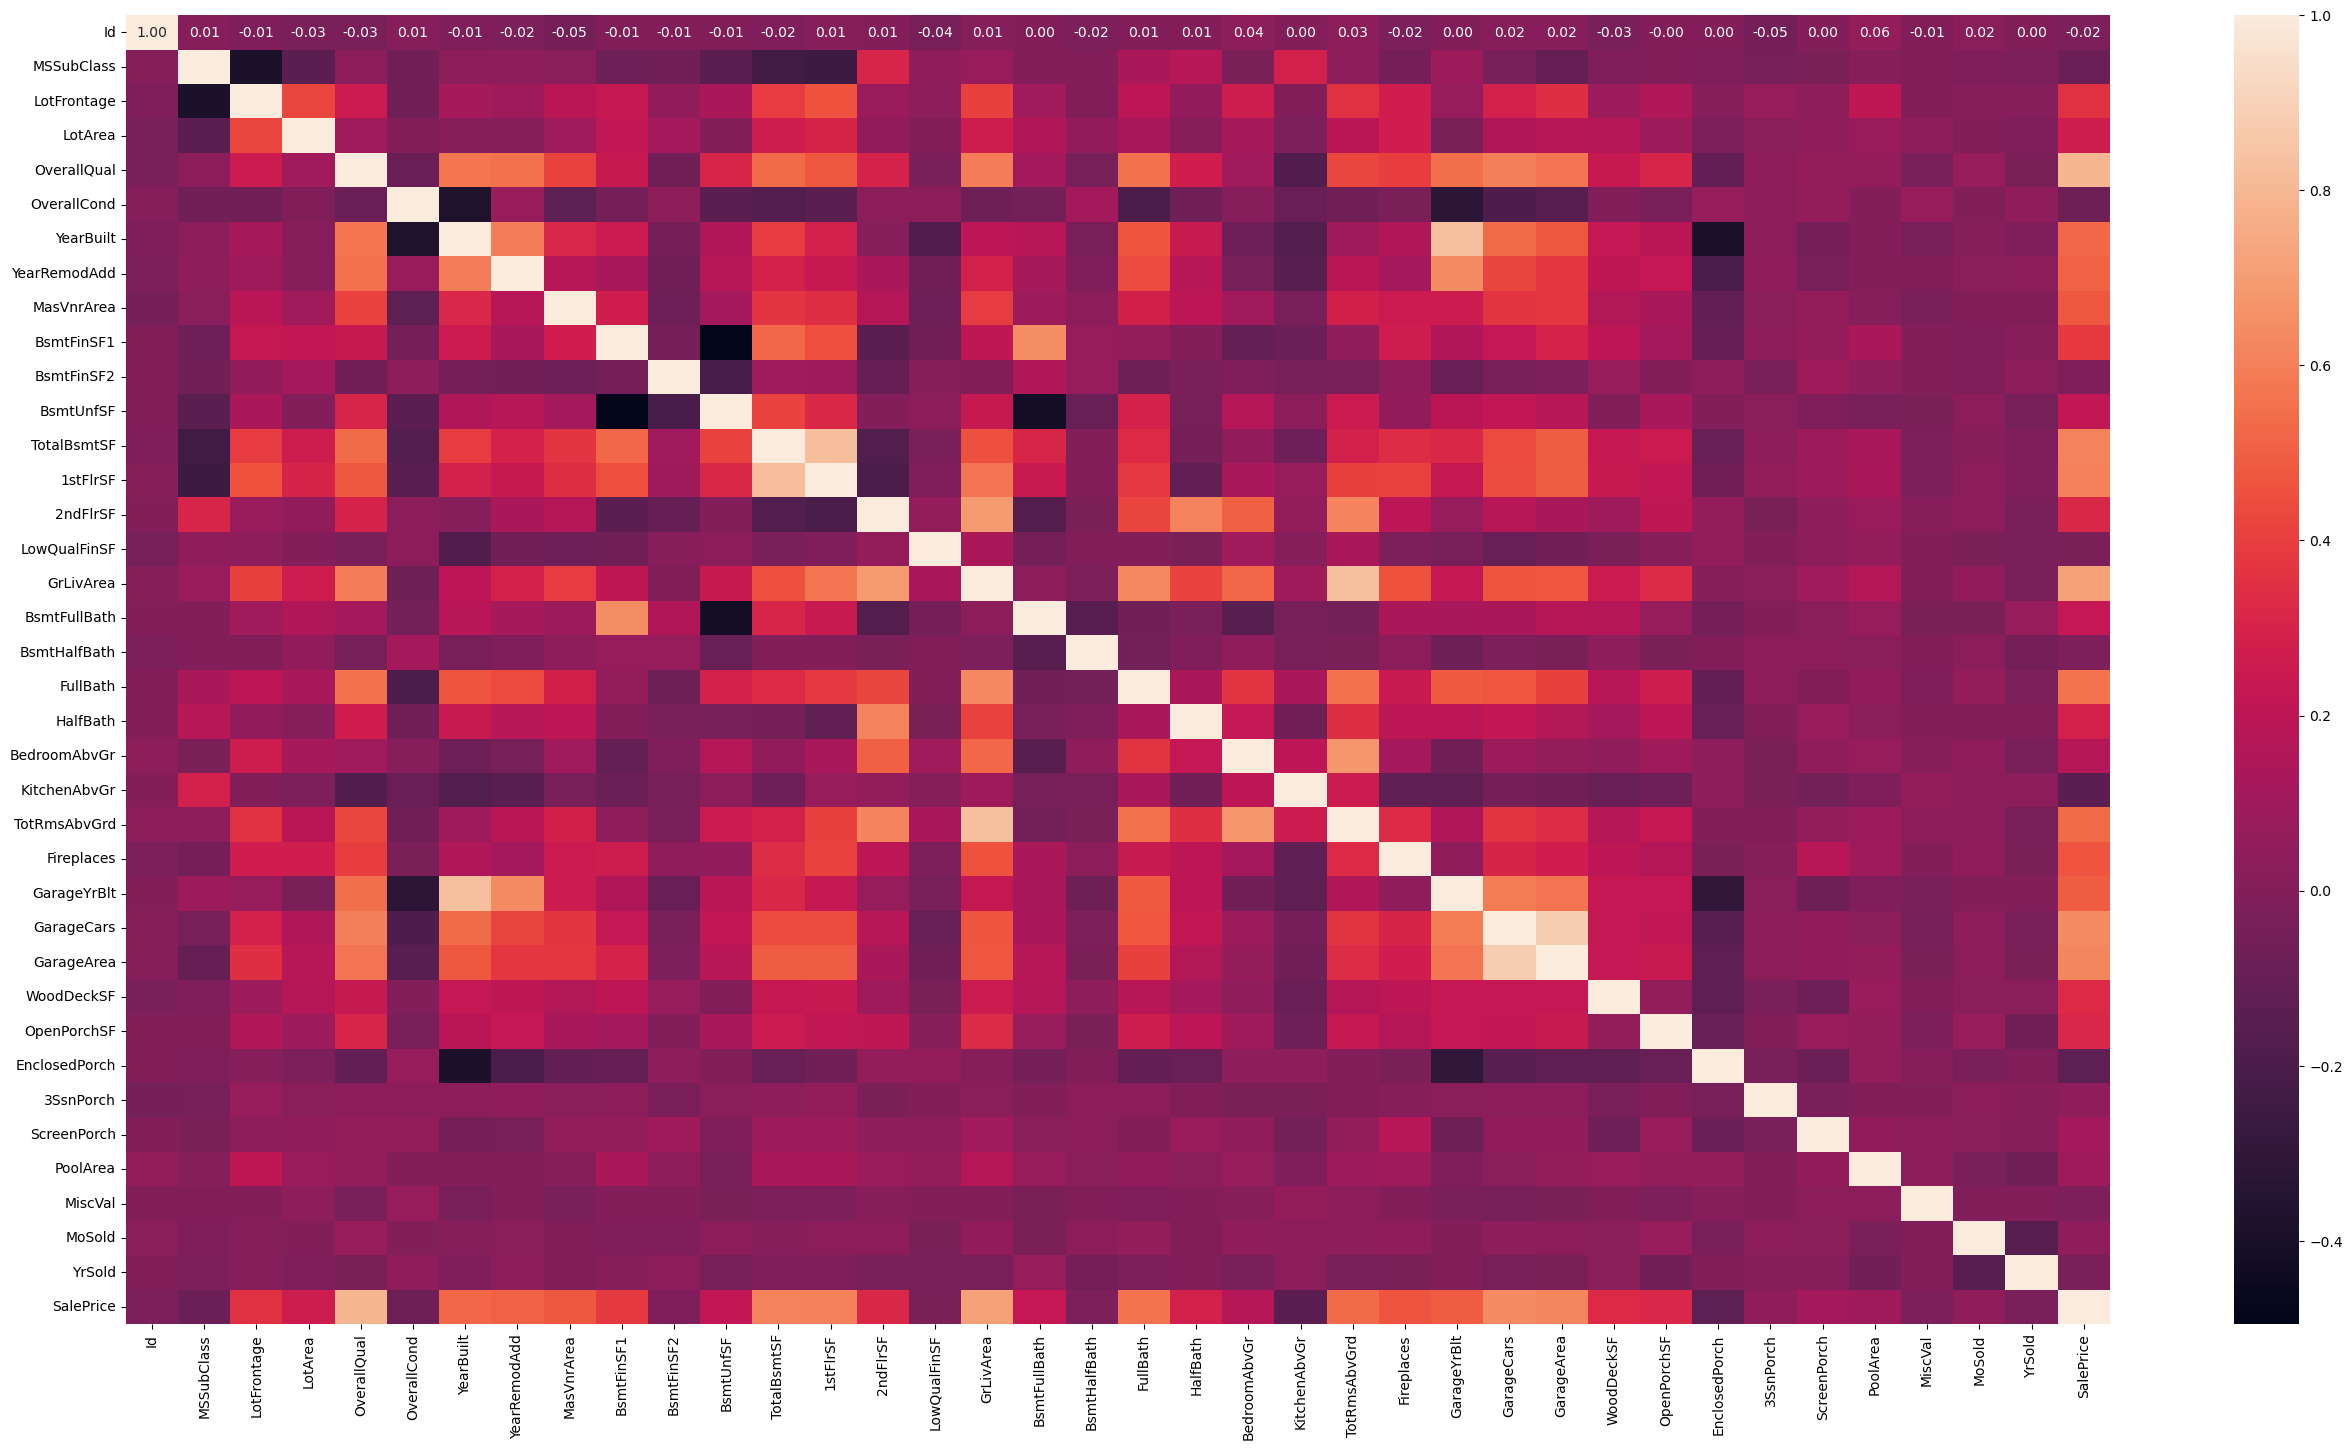

In [10]:
num_df = train[train.select_dtypes(include=['int', 'float']).columns.tolist()]
plt.rcParams['figure.figsize'] = [32,17]
sns.heatmap(num_df.corr(), annot=True, fmt='.2f')

#### Просмотр корреляции всех численных признаков с таргетом - "SalePrice" 

In [11]:
num_cor = num_features.corr()['SalePrice'].sort_values(ascending=False).reset_index()
num_cor

,index,SalePrice
0,SalePrice,1.000000
1,OverallQual,0.790982
2,GrLivArea,0.708624
3,GarageCars,0.640409
4,GarageArea,0.623431
5,TotalBsmtSF,0.613581
6,1stFlrSF,0.605852
7,FullBath,0.560664
8,TotRmsAbvGrd,0.533723
9,YearBuilt,0.522897


In [12]:
# Иходя из проведенной корреляции выше, выводим численные фичи, у которых корреляция < 0.05, для дальнейшего удаления
drop_num_features = ["MoSold", "3SsnPorch", "BsmtFinSF2", "BsmtHalfBath", "MiscVal", "Id", "LowQualFinSF", "YrSold", "PoolArea", "OverallCond", "MSSubClass"]

### 5. Разбивка датафрейма train на тренировочный и валидационный

In [13]:
X, y = train.drop("SalePrice", axis=1), train["SalePrice"]

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

### 6. Просмотр пропусков

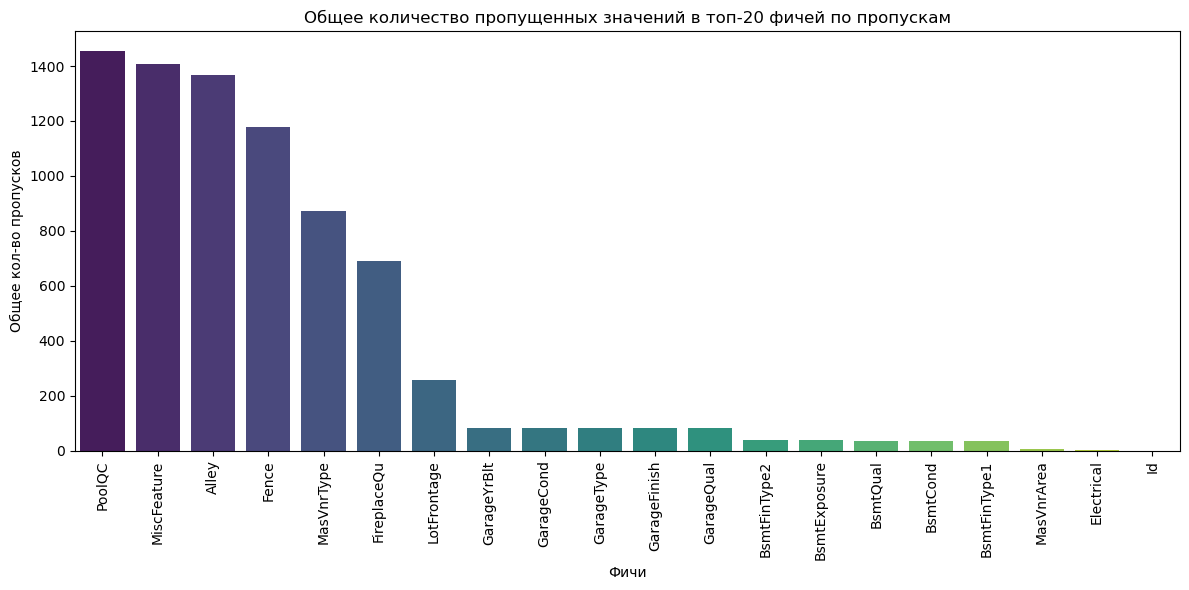

In [15]:
total = train.isnull().sum().sort_values(ascending=False)

# Выбираем топ 20 фичей с наибольшим количеством пропусков
top_18_missing = total.head(20)

# Строим barplotдля визуализации топ-20 фичей с наибольшим количеством пропусков
plt.figure(figsize=(12, 6))  
sns.barplot(x=top_18_missing.index, y=top_18_missing.values, palette='viridis')  
plt.xticks(rotation=90)  
plt.title('Общее количество пропущенных значений в топ-20 фичей по пропускам') 
plt.xlabel('Фичи')  
plt.ylabel('Общее кол-во пропусков')  
plt.tight_layout()  
plt.show() 

### 7. Определение фичей с набильшим количеством пропусков для дальнейшего удаления

In [16]:
num_features = X.select_dtypes(exclude='object')
cat_features = X.select_dtypes(include='object')

# Обработка пропущенных значений
nan_num = pd.DataFrame(data={'nan':  num_features.isna().sum()})
nan_cat = pd.DataFrame(data={'nan':  cat_features.isna().sum()})

# Запись фичей с количеством пропусков > 500 для дальнейшего удаления
drop_nan_cat = nan_cat[nan_cat['nan']>500]['nan'].index.to_list()

# Объединяем фичи, которые мы планируем удалять в одну переменную: drop_nan_cat из пункта 7 и drop_num_features из пункта 4
drop_features = drop_nan_cat + drop_num_features 

# Выводим оставшиеся фичи с пропусками, но у которых пропусков < 500
num_trans = nan_num[nan_num['nan']>0]['nan'].index.to_list()
cat_trans = nan_cat[nan_cat['nan']>0]['nan'].index.to_list()


### 8. Кодировка данных 

##### Drop неважных фичей и пропусков

In [17]:
# drop_features из пункта 7 мы перезаписываем в новую переменную "drop"
drop = [
    'Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature',
    'MoSold', '3SsnPorch', 'BsmtFinSF2', 'BsmtHalfBath', 'MiscVal', 'Id',
    'LowQualFinSF', 'YrSold'
]

# Создаем переменные с категориальными и числовыми признаками/фичами, которые имеют пропуски:
# - num_imp_avg - переменная с числовыми фичами, но у которых не прописано условие NA в файле data_description.txt => что мы заменяем пропуски на "mean"
# - cat_imp_mode - переменная с категориальными фичами, но у которых не прописано условие NA в файле data_description.txt => что мы заменяем пропуски на "most_frequent"
# - cat_imp_no - переменная с категориальными фичами, но у которых прописано условие NA в файле data_description.txt => что мы заменяем пропуски на константу, а именно: вместо пропуска прописываем "missing", поскольку
# это категориальная фича, то и замену пропуска необходимо заменять на строку, а именно аргумент "missing"

num_imp_avg = ["LotFrontage", "GarageYrBlt", "MasVnrArea", "BsmtFinSF1", "BsmtUnfSF", "TotalBsmtSF", "BsmtFullBath", "GarageCars", "GarageArea"]
cat_imp_mode = ["Functional", "Utilities", "Electrical"]
cat_imp_no = [
    "GarageCond", "GarageType", "GarageFinish", "GarageQual", "BsmtFinType2",
    "BsmtExposure", "BsmtQual", "BsmtCond", "BsmtFinType1"
]


my_imputer = ColumnTransformer(
    transformers=[
        ("drop_features", "drop", drop),  
        ("num_imp_avg", SimpleImputer(strategy="mean"), num_imp_avg),
        ("cat_imp_mode", SimpleImputer(strategy="most_frequent"), cat_imp_mode),
        ("cat_imp_no", SimpleImputer(strategy="constant", fill_value="missing"), cat_imp_no),
    ],
    remainder="passthrough",  
    verbose_feature_names_out=False  
)


#### Кодирование категориальных признаков

In [18]:
# Кодирование категориальных признаков
# Признаки для кодирования мы выбираем по следующему принципу: 
# mas_one_hot_encoder = [i for i in car_features.columns.to_list() if 2 < train[i].unique().size < 6]
# mas_ordinal_encoder = [i for i in car_features.columns.to_list() if 3 > train[i].unique().size]
# mas_target_encoder = [i for i in car_features.columns.to_list() if 5 < train[i].unique().size]

mas_one_hot_encoder = ['ExterQual', 'HeatingQC', 'ExterCond', 'BsmtCond', 'BldgType', 'LotShape', 'LotConfig', 'GarageFinish', 'KitchenQual', 'PavedDrive', 'BsmtQual', 'BsmtExposure', 'LandSlope', 'LandContour', 'MSZoning']
mas_ordinal_encoder = ['Street', 'Utilities', 'CentralAir']
mas_target_encoder = ['RoofStyle', 'Exterior1st', 'GarageQual', 'Foundation', 'Exterior2nd', 'HouseStyle', 'Condition2', 'GarageType', 'Neighborhood', 'GarageCond', 'BsmtFinType2', 'Heating', 'Functional', 'RoofMatl', 'Condition1', 'Electrical', 'SaleCondition', 'SaleType', 'BsmtFinType1']

my_encoder = ColumnTransformer(
    [
        ("ordinalEncoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), mas_ordinal_encoder),
        ("oneHotEncoder", OneHotEncoder(handle_unknown='ignore', sparse_output=False), mas_one_hot_encoder),
        ("targetencoder", TargetEncoder(), mas_target_encoder)
    ],
    verbose_feature_names_out=False,
    remainder='passthrough'
)



#### Нормализация данных через StandardScaler

In [19]:
# Масштабирование числовых признаков
standart_scaler_columns = ['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFullBath', 'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr', 'LotArea', 'LotFrontage', 'MSSubClass', 'MasVnrArea', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'PoolArea', 'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd']
drop_scaler = [ 'GarageFinish_missing', 'GarageQual', 'GarageCond', 'BsmtQual_missing',
    'BsmtExposure_missing', 'BsmtExposure_missing']

my_scaler = ColumnTransformer(
    [
        ("scaling_num_columns", StandardScaler(), standart_scaler_columns),
        ("drop_feat", "drop", drop_scaler)
    ],
    verbose_feature_names_out=False,
    remainder="passthrough"
)


#### Построение пайплайна предобработки данных 

In [20]:
preprocessor = Pipeline(
    [
        ("imputer", my_imputer),
        ("encoder", my_encoder),
        ("scaler", my_scaler)
    ]
)


In [21]:
# Обучение пайплайна
preprocessor.fit_transform(X_train, np.log(y_train))

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtFinSF1,BsmtFullBath,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageArea,...,Neighborhood,BsmtFinType2,Heating,Functional,RoofMatl,Condition1,Electrical,SaleCondition,SaleType,BsmtFinType1
254,0.374235,-0.801923,0.136218,1.037269,1.105320,-0.400282,-0.351921,-0.958592,-1.055566,-0.863837,...,11.877946,12.048091,12.039718,12.046337,12.02747,12.047749,12.065213,12.009405,12.000702,11.856979
1066,-0.958202,0.955088,0.136218,-0.971996,-0.818694,0.511920,-0.351921,0.592150,0.773664,-0.456264,...,12.172817,12.048091,12.039718,12.046337,12.02747,12.047749,12.065213,12.009405,12.000702,11.989991
638,-0.965964,-0.801923,-1.106774,-0.971996,-0.818694,0.505196,2.290826,-0.958592,-1.055566,-2.257169,...,11.712457,12.048091,12.039718,12.046337,12.02747,11.822188,11.688288,12.009405,12.000702,11.989991
799,-0.487321,0.989227,0.136218,0.267995,1.105320,-0.915776,3.902257,2.142892,-1.055566,-1.119755,...,11.936318,12.048091,12.039718,12.046337,12.02747,11.822188,12.065213,12.009405,12.000702,11.949438
380,-0.370895,0.711564,0.136218,-0.496920,-0.818694,0.532091,3.547742,0.592150,0.773664,-0.797488,...,11.936318,12.048091,12.039718,12.046337,12.02747,12.047749,12.065213,12.009405,12.000702,11.874652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,0.374235,-0.801923,0.136218,-0.919694,-0.818694,1.612389,-0.351921,0.592150,0.773664,-0.171910,...,12.179068,12.048091,12.039718,12.046337,12.02747,12.047749,12.065213,12.009405,12.000702,12.299914
1130,0.410457,0.684253,1.379210,0.383495,1.105320,-0.158223,-0.351921,2.142892,0.773664,0.472624,...,11.936318,12.048091,12.039718,11.895044,12.02747,12.047749,12.065213,12.009405,12.000702,11.888927
1294,-0.790030,-0.801923,-1.106774,-0.608062,1.105320,0.283309,-0.351921,-0.958592,-1.055566,0.453667,...,11.712457,12.048091,12.039718,12.046337,12.02747,12.047749,12.065213,12.009405,12.000702,11.856979
860,-0.665842,0.367900,0.136218,-0.971996,-0.818694,0.765184,-0.351921,0.592150,-1.055566,-1.233497,...,12.194192,12.048091,12.039718,12.046337,12.02747,12.047749,12.065213,12.009405,12.000702,11.989991


### 9. Создание модели

In [22]:

# Определение функции для Optuna
# def objective(trial):
#     params = {
#         'iterations': trial.suggest_int('iterations', 500, 1500),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
#         'depth': trial.suggest_int('depth', 4, 10),
#         'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100),
#         'random_strength': trial.suggest_uniform('random_strength', 1e-8, 10),
#         'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),
#         'border_count': trial.suggest_int('border_count', 32, 255),
#         'verbose': False
#     }
#     ml_pipeline = Pipeline(
#         [
#             ("preprocessor", preprocessor),
#             ("model", CatBoostRegressor(**params))
#         ]
#     )

#     ml_pipeline.fit(X_train, np.log(y_train))
#     y_pred = ml_pipeline.predict(X_valid)
#     msle = mean_squared_error(np.log(y_valid), y_pred)

#     return msle

# # Оптимизация с помощью Optuna
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50)

# # Лучшие параметры
# best_params = study.best_params
# print("Best parameters:", best_params)

# # Обучение модели с лучшими параметрами
# ml_pipeline = Pipeline(
#     [
#         ("preprocessor", preprocessor),
#         ("model", CatBoostRegressor(**best_params))
#     ]
# )
# ml_pipeline.fit(X_train, np.log(y_train))

# # Предсказание на тестовых данных
# testy_preds = ml_pipeline.predict(test)

# # Оценка качества
# print('MSLE:', mean_squared_error(np.log(submission['SalePrice']), testy_preds))

# # Сохранение результатов
# result = pd.DataFrame({'Id': test['Id'], 'SalePrice': np.exp(testy_preds)})
# result.to_csv('model2.csv', index=False)

In [23]:
# Определение функции для Optuna с использованием KFold
def objective(trial):
    # Гиперпараметры для оптимизации
    params = {
        'iterations': trial.suggest_int('iterations', 500, 1500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100),
        'random_strength': trial.suggest_uniform('random_strength', 1e-8, 10),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'verbose': False
    }

    # Инициализация KFold
    kf = KFold(n_splits=5, random_state=333, shuffle=True)
    msle_scores = []

    # Кросс-валидация
    for train_index, valid_index in kf.split(X):
        X_train_fold, X_valid_fold = X.iloc[train_index], X.iloc[valid_index]
        y_train_fold, y_valid_fold = y.iloc[train_index], y.iloc[valid_index]

        # Создание пайплайна
        ml_pipeline = Pipeline(
            [
                ("preprocessor", preprocessor),
                ("model", CatBoostRegressor(**params))
            ]
        )

        # Обучение модели на текущем фолде
        ml_pipeline.fit(X_train_fold, np.log(y_train_fold))

        # Предсказание и оценка на валидационном фолде
        y_pred_fold = ml_pipeline.predict(X_valid_fold)
        msle = mean_squared_error(np.log(y_valid_fold), y_pred_fold)
        msle_scores.append(msle)

    # Возвращаем средний MSLE по всем фолдам
    return np.mean(msle_scores)

# Оптимизация с помощью Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Лучшие параметры
best_params = study.best_params
print("Best parameters:", best_params)

# Обучение финальной модели на всех данных с лучшими параметрами
ml_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("model", CatBoostRegressor(**best_params))
    ]
)
ml_pipeline.fit(X, np.log(y))

# Предсказание на тестовых данных
testy_preds = ml_pipeline.predict(test)

# Оценка качества
print('MSLE:', mean_squared_error(np.log(submission['SalePrice']), testy_preds))

# Сохранение результатов
result = pd.DataFrame({'Id': test['Id'], 'SalePrice': np.exp(testy_preds)})
result.to_csv('model3_optuna_kfold.csv', index=False)

[I 2025-03-14 15:58:31,276] A new study created in memory with name: no-name-b2976df1-f21d-4ffe-ae5c-4a27f709986e
/tmp/ipykernel_538336/2209797925.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
/tmp/ipykernel_538336/2209797925.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100),
/tmp/ipykernel_538336/2209797925.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'random_strength': trial.sug

Best parameters: {'iterations': 1313, 'learning_rate': 0.015938051705911255, 'depth': 5, 'l2_leaf_reg': 3.313191848543509e-07, 'random_strength': 1.1473545845237094, 'bagging_temperature': 0.151356221497692, 'border_count': 154}
0:	learn: 0.3950384	total: 1.34ms	remaining: 1.76s
1:	learn: 0.3909957	total: 3.25ms	remaining: 2.13s
2:	learn: 0.3871031	total: 5.23ms	remaining: 2.29s
3:	learn: 0.3828963	total: 7.71ms	remaining: 2.52s
4:	learn: 0.3789726	total: 9.2ms	remaining: 2.41s
5:	learn: 0.3752114	total: 10.5ms	remaining: 2.3s
6:	learn: 0.3712340	total: 13.3ms	remaining: 2.47s
7:	learn: 0.3675017	total: 16.1ms	remaining: 2.63s
8:	learn: 0.3638466	total: 18.6ms	remaining: 2.69s
9:	learn: 0.3603098	total: 20.9ms	remaining: 2.73s
10:	learn: 0.3570025	total: 22.8ms	remaining: 2.7s
11:	learn: 0.3536639	total: 24.5ms	remaining: 2.66s
12:	learn: 0.3500747	total: 26.9ms	remaining: 2.69s
13:	learn: 0.3464882	total: 30.5ms	remaining: 2.83s
14:	learn: 0.3432600	total: 34.8ms	remaining: 3.01s
15:	

### 10. Проверка корреляции после обучения модели:

In [24]:
corr_matrix = pd.DataFrame(preprocessor.fit_transform(X_train, y_train)).corr()
# Порог корреляции
threshold = 0.8

# Выводим пары признаков с корреляцией выше порога
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            print(f"Пара: {corr_matrix.columns[i]} - {corr_matrix.columns[j]}, Корреляция: {corr_matrix.iloc[i, j]:.2f}")

Пара: 1stFlrSF - TotalBsmtSF, Корреляция: 0.83
Пара: GarageArea - GarageCars, Корреляция: 0.88
Пара: GrLivArea - TotRmsAbvGrd, Корреляция: 0.82
Пара: MSSubClass - BldgType_1Fam, Корреляция: -0.82
Пара: ExterQual_Gd - ExterQual_TA, Корреляция: -0.91
Пара: ExterCond_Gd - ExterCond_TA, Корреляция: -0.89
Пара: BsmtCond_missing - BsmtFinType2, Корреляция: -0.86
Пара: LotShape_IR1 - LotShape_Reg, Корреляция: -0.92
Пара: KitchenQual_Gd - KitchenQual_TA, Корреляция: -0.83
Пара: PavedDrive_N - PavedDrive_Y, Корреляция: -0.85
Пара: LandSlope_Gtl - LandSlope_Mod, Корреляция: -0.92
Пара: MSZoning_RL - MSZoning_RM, Корреляция: -0.81
Пара: Exterior1st - Exterior2nd, Корреляция: 0.94
Пара: SaleCondition - SaleType, Корреляция: 0.97


In [25]:
# После этого мы определяем фичи, которые мы можем выкинуть из нашего датафрейма и после этого обновляем пункт 8 и заново переобучаем модель